# Compare predictions and results
After making recommendaitons and passing them to David, we can compare the predicted titer for our recommendations with their results (i.e. the data from DBTL2).

In [1]:
import edd_utils as eddu
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re 
import random
random.seed(1)

In [2]:
fig_loc = './dbtl1_figures_and_analysis_filter/'

## Import data and recommendations

In [3]:
rec_df = pd.read_csv('./dbtl1_figures_and_analysis_filter/filtered_recs_for_dbtl2.csv', index_col=0)
rec_df.head(3)

,line_name,pp_mean,pp_std,number_of_grna,in_expt,to_rec
118077,PP_0528_PP_0815_PP_1317_PP_4191,522.647032,75.405264,4,0,1
112467,PP_0528_PP_0751_PP_0815_PP_1317,512.640343,73.305519,4,0,1
115852,PP_0528_PP_0813_PP_0815_PP_1317,505.477196,71.580319,4,0,1


In [4]:
data_df = pd.read_pickle('./isoprenol_data/dbtl2_isoprenol.pkl')
data_df.head(3)

,Study ID,Study Name,Line ID,Replicate Key,Line Name,Line Description,Protocol,Assay ID,Assay Name,Formal Type,Measurement Type,Compartment,Units,Value,Hours
0,194881,CRISPRi automation for enhanced isoprenol prod...,194882,c86dfaf3-ec02-463c-96c8-f8fe122b02cc,PP_0528_PP_0815_PP_1317_PP_4191-R1,DBTL2_P1_001,GC-FID,195074,PP_0528_PP_0815_PP_1317_PP_4191-R1,cid:12988,3-METHYL-3-BUTEN-1-OL,0,mg/L,201.9179,48.0
1,194881,CRISPRi automation for enhanced isoprenol prod...,194883,c76bdfef-08b8-463c-8c1e-324e10fe5eee,PP_0528_PP_0813_PP_0815_PP_1317-R1,DBTL2_P1_002,GC-FID,195075,PP_0528_PP_0813_PP_0815_PP_1317-R1,cid:12988,3-METHYL-3-BUTEN-1-OL,0,mg/L,392.7469,48.0
2,194881,CRISPRi automation for enhanced isoprenol prod...,194884,0d59d68e-24f6-4d82-9235-787339f485bd,PP_0528_PP_0814_PP_0815_PP_1317-R1,DBTL2_P1_003,GC-FID,195076,PP_0528_PP_0814_PP_0815_PP_1317-R1,cid:12988,3-METHYL-3-BUTEN-1-OL,0,mg/L,457.0174,48.0


## Format data 

### Drop unneeded columns

In [5]:
columns_to_keep = ['Line Name', 'Value']
data_df = data_df[columns_to_keep]
data_df

,Line Name,Value
0,PP_0528_PP_0815_PP_1317_PP_4191-R1,201.9179
1,PP_0528_PP_0813_PP_0815_PP_1317-R1,392.7469
2,PP_0528_PP_0814_PP_0815_PP_1317-R1,457.0174
3,PP_0528_PP_0813_PP_4191-R1,361.4189
4,PP_0528_PP_0751_PP_4191-R1,321.5996
...,...,...
187,PP_1769_PP_4192-R3,253.1558
188,PP_0368_PP_0812-R3,297.0306
189,PP_1317-R3,451.4621
190,PP_0815_PP_1317-R3,455.1851


### Add replicate column

In [6]:
data_df['rep'] = data_df['Line Name'].apply(lambda x: int(x[-1]))

### Add line name with no rep

In [7]:
data_df['line_name_norep'] = data_df['Line Name'].apply(lambda x: x.split('-')[0])

### Identify and drop controls

In [8]:
data_df.shape

(192, 4)

In [9]:
data_df['is_control'] = data_df['Line Name'].apply(lambda x: 'ontrol' in x)
data_df = data_df[~data_df['is_control']]

In [10]:
data_df.shape

(180, 5)

In [11]:
data_df.head(3)

,Line Name,Value,rep,line_name_norep,is_control
0,PP_0528_PP_0815_PP_1317_PP_4191-R1,201.9179,1,PP_0528_PP_0815_PP_1317_PP_4191,False
1,PP_0528_PP_0813_PP_0815_PP_1317-R1,392.7469,1,PP_0528_PP_0813_PP_0815_PP_1317,False
2,PP_0528_PP_0814_PP_0815_PP_1317-R1,457.0174,1,PP_0528_PP_0814_PP_0815_PP_1317,False


### Drop lines w/ no predictions

In [12]:
any('PP_0528_PP_0815_PP_1317_PP_4191' == rec_df['line_name'])

True

In [13]:
'PP_0528_PP_0815_PP_1317_PP_4191' in rec_df['line_name']

False

In [14]:
def has_rec(line, all_rec_lines):
    return any(line == all_rec_lines)

data_df.loc[:,'has_rec'] = data_df['line_name_norep'].apply(lambda x: has_rec(x, rec_df['line_name'].unique()))
data_df.head(3)

/tmp/ipykernel_54979/3146226239.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_df.loc[:,'has_rec'] = data_df['line_name_norep'].apply(lambda x: has_rec(x, rec_df['line_name'].unique()))


,Line Name,Value,rep,line_name_norep,is_control,has_rec
0,PP_0528_PP_0815_PP_1317_PP_4191-R1,201.9179,1,PP_0528_PP_0815_PP_1317_PP_4191,False,True
1,PP_0528_PP_0813_PP_0815_PP_1317-R1,392.7469,1,PP_0528_PP_0813_PP_0815_PP_1317,False,True
2,PP_0528_PP_0814_PP_0815_PP_1317-R1,457.0174,1,PP_0528_PP_0814_PP_0815_PP_1317,False,True


In [15]:
data_df = data_df[data_df['has_rec']]
data_df.shape

(174, 6)

## make dataframe for predictions and data

In [16]:
df = pd.DataFrame(columns = ['line'])
df['line'] = data_df['line_name_norep'].unique()
df.head(3)

,line
0,PP_0528_PP_0815_PP_1317_PP_4191
1,PP_0528_PP_0813_PP_0815_PP_1317
2,PP_0528_PP_0814_PP_0815_PP_1317


### Add experimental data to df

In [17]:
df.loc[:, 'mean'] = df['line'].apply(lambda x: 
                                     np.mean(
                                         data_df.loc[data_df['line_name_norep'] == x, 'Value']
                                     ))

df.loc[:, 'std'] = df['line'].apply(lambda x: 
                                     np.std(
                                         data_df.loc[data_df['line_name_norep'] == x, 'Value']
                                     ))

### Add predictions to df

In [18]:
rec_df.head(3)

,line_name,pp_mean,pp_std,number_of_grna,in_expt,to_rec
118077,PP_0528_PP_0815_PP_1317_PP_4191,522.647032,75.405264,4,0,1
112467,PP_0528_PP_0751_PP_0815_PP_1317,512.640343,73.305519,4,0,1
115852,PP_0528_PP_0813_PP_0815_PP_1317,505.477196,71.580319,4,0,1


In [19]:
rec_df.loc[rec_df['line_name'] == 'PP_0528_PP_0813_PP_0815_PP_1317', 'pp_mean'].values[0]

505.4771961584421

In [20]:
df.loc[:, 'pred_mean'] = df['line'].apply(lambda x: 
                                         rec_df.loc[rec_df['line_name'] == x, 'pp_mean']
                                     ).values[0]

df.loc[:, 'pred_std'] = df['line'].apply(lambda x: 
                                         rec_df.loc[rec_df['line_name'] == x, 'pp_std']
                                     ).values[0]


In [21]:
for idx, srs in df.iterrows():
    pred_mean_values = rec_df.loc[rec_df['line_name'] == srs['line'], 'pp_mean'].values
    pred_std_values = rec_df.loc[rec_df['line_name'] == srs['line'], 'pp_std'].values

    if len(pred_mean_values) == 1:
        df.loc[idx, 'pred_mean'] = pred_mean_values[0]
        df.loc[idx, 'pred_std'] = pred_std_values[0]
        

In [22]:
df.head(3)

,line,mean,std,pred_mean,pred_std
0,PP_0528_PP_0815_PP_1317_PP_4191,220.1254,12.983750,522.647032,75.405264
1,PP_0528_PP_0813_PP_0815_PP_1317,389.2000,6.828659,505.477196,71.580319
2,PP_0528_PP_0814_PP_0815_PP_1317,450.4765,12.536700,496.568803,73.066223


<Axes: xlabel='mean', ylabel='pred_mean'>

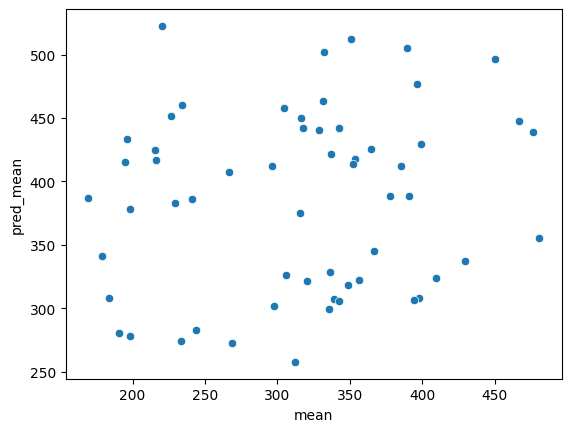

In [23]:
sns.scatterplot(data = df, x = 'mean', y = 'pred_mean')

Text(200, 100, 'Pearson R = 0.152\np = 0.255\nR^2 = -1.245\nMAE = 97.637')

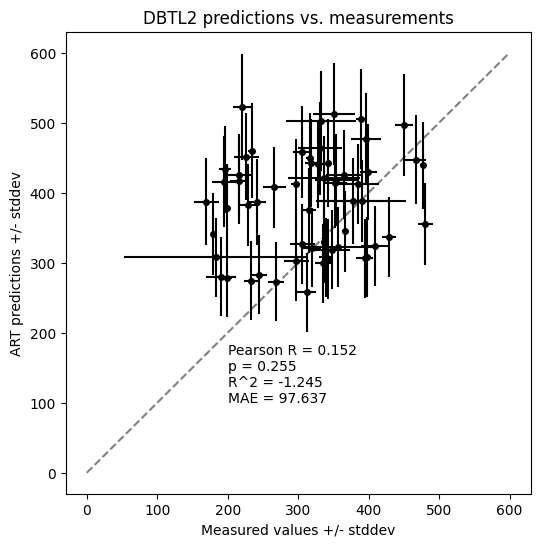

In [27]:
from scipy.stats import pearsonr
from sklearn.metrics import r2_score, mean_absolute_error


fig, ax = plt.subplots(figsize = (6,6))
plt.plot([0, 600], [0, 600], color = 'grey', linestyle = '--')

plt.errorbar(x = df['mean'], xerr=df['std'], y = df['pred_mean'], yerr = df['pred_std'],
             linestyle = '', marker = '.', markersize = 8, markerfacecolor = 'k', markeredgecolor = 'k', ecolor = 'k')
ax.set_ylabel('ART predictions +/- stddev')
ax.set_xlabel('Measured values +/- stddev')

s,p = pearsonr(df['mean'], df['pred_mean'])
r2 = r2_score(df['mean'], df['pred_mean'])
mae = mean_absolute_error(df['mean'], df['pred_mean'])
ax.set_title(f"DBTL2 predictions vs. measurements")
ax.text(200, 100, f"Pearson R = {s:.3f}\np = {p:.3f}\nR^2 = {r2:.3f}\nMAE = {mae:.3f}")